In [1]:
%matplotlib inline
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, Conv2D, Input, RepeatVector
from keras.layers import Reshape, concatenate, Conv2DTranspose
from keras import layers, optimizers
from scipy import stats
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
DATA_PATH = 'data/'
X_IMG_PATH = DATA_PATH + 'images/'
Y_IMG_PATH = DATA_PATH + 'labels/'

INPUT_SIZE = (128, 128)

In [3]:
def preprocess_img(filepath, test_img=False):
    img = cv2.imread(filepath)
    img_resized = cv2.resize(img, INPUT_SIZE)
    
    if test_img:
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        img_resized = np.expand_dims(img_resized, 3)
        img_resized = (img_resized > .5).astype(np.float32)
        
    return img_resized

files = os.listdir(X_IMG_PATH)
images_all = np.array([preprocess_img(X_IMG_PATH + fname) for fname in files])
labels_all = np.array([preprocess_img(Y_IMG_PATH + fname, True) for fname in files])

/home/mateusz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  import sys


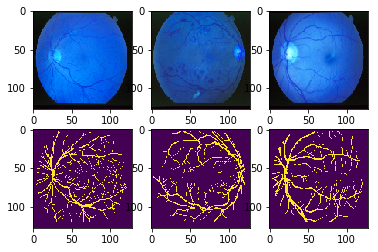

In [4]:
N_SHOW = 3  # How many examples should be shown
f, axarr = plt.subplots(2, N_SHOW)

for i in range(N_SHOW):
    axarr[0, i].imshow(images_all[i])
    axarr[1, i].imshow(labels_all[i,:,:,0])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images_all,
                                                    labels_all,
                                                    test_size=0.2)
images_all.shape

(20, 128, 128, 3)

In [6]:
# Source: https://www.kaggle.com/bguberfain/unet-with-depth
input_img = Input((*INPUT_SIZE, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

optimizer = optimizers.Adam(lr=1e-4)
model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [8]:
model.fit(X_train, y_train,
          batch_size=16, epochs=50,
          validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 16 samples, validate on 4 samples
Epoch 1/50
16/16 [==============================] - 3s 209ms/step - loss: 1.0388 - acc: 0.6205 - val_loss: 0.9469 - val_acc: 0.8420
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.9350 - acc: 0.8459 - val_loss: 0.9330 - val_acc: 0.8597
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.9211 - acc: 0.8658 - val_loss: 0.7814 - val_acc: 0.8675
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.7751 - acc: 0.8741 - val_loss: 0.5915 - val_acc: 0.8724
Epoch 5/50
16/16 [==============================] - 0s 3ms/step - loss: 0.5894 - acc: 0.8790 - val_loss: 0.4801 - val_acc: 0.8759
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.4726 - acc: 0.8822 - val_loss: 0.5169 - val_acc: 0.8784
Epoch 7/50
16/16 [==============================] - 0s 3ms/step - loss: 0.5087 - acc: 0.8852 - val_loss: 0.5533 - val_acc: 0.88

In [9]:
def process_predictions(y_hat):
    new_shape = (y_hat.shape[0], *INPUT_SIZE)
    y_proc = np.reshape(y_hat, new_shape)
    return y_proc

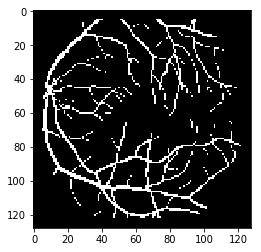

In [10]:
y_true_proc = process_predictions(y_test)
plt.imshow(y_true_proc[0], cmap='gray')

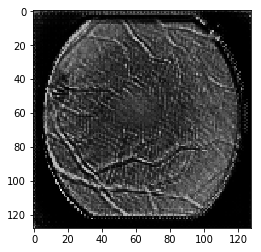

In [11]:
y_hat = model.predict(X_test)
y_hat_proc = process_predictions(y_hat)
plt.imshow(y_hat_proc[0], cmap='gray')